### Deep Image Similarity Matching System

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score

from sklearn.metrics.pairwise import cosine_similarity
import os
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import random
import time
import tensorflow as tf
from keras.models import Model, load_model
import tensorflow as tf
from sklearn.metrics import precision_recall_curve, auc, roc_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Concatenate, Dense, Flatten, GlobalAveragePooling2D, Input, Lambda
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics.pairwise import cosine_similarity
from keras.callbacks import Callback
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

#Data-Preprocessing

In [ ]:
# Define paths to your data directories
train_left_dir = '/train/left'
train_right_dir = '/train/right'
train_df = pd.read_csv('/train.csv')

In [5]:
# Function to load and preprocess an image
def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is not None:
        h, w, _ = image.shape
        diff = abs(h - w)
        pad1, pad2 = diff // 2, diff - diff // 2
        if h > w:
            padding = ((0, 0), (pad1, pad2), (0, 0))
        else:
            padding = ((pad1, pad2), (0, 0), (0, 0))
        image = np.pad(image, padding, mode='constant', constant_values=255)
        image = cv2.resize(image, (128, 128))  # Resize images to 128x128 to match ResNet50 input size (actually, 224x224 for original ResNet50)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        image = tf.keras.applications.resnet.preprocess_input(image)
  # Preprocess for ResNet152
    return image

# Load and preprocess training images
train_left_images = [load_and_preprocess_image(os.path.join(train_left_dir, img + ".jpg")) for img in train_df['left']]
train_right_images = [load_and_preprocess_image(os.path.join(train_right_dir, img + ".jpg")) for img in train_df['right']]

2000
2000
(128, 128, 3)
float32


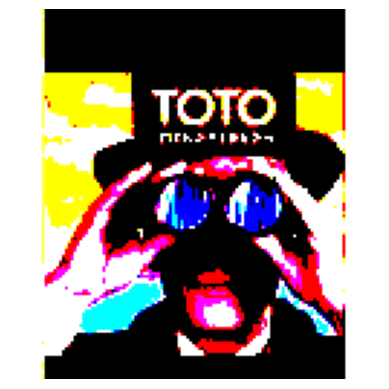

In [6]:
# Check the length of the lists (i.e., the number of images)
print(len(train_left_images))
print(len(train_right_images))

# Check the shape and data type of the first image
print(train_left_images[0].shape)
print(train_left_images[0].dtype)

plt.imshow(train_left_images[0])
plt.axis('off')
plt.show()

Make it so that there's one on the left and twenty on the right, corresponding to the label

In [7]:
# Get all image paths in the directory
all_right_images_paths = [os.path.join(train_right_dir, img) for img in os.listdir(train_right_dir)]

# Create a new list to store all combined image sets
combined_images_list = []

for eachRight in train_right_images:
    # Randomly select an image from train_right_images
    chosen_right_image_path = random.choice(all_right_images_paths)
    chosen_right_image = load_and_preprocess_image(chosen_right_image_path)

    # Randomly select 19 different images from train_right_dir, random_sample_images already contains 19 images#10
    random_sample_paths = random.sample([path for path in all_right_images_paths if path != chosen_right_image_path], 9)
    random_sample_images = [load_and_preprocess_image(path) for path in random_sample_paths]

    # Create a new list combined_images, which contains images from eachRight and random_sample_images
    combined_images = [eachRight] + random_sample_images
    combined_images = [eachRight] + random_sample_images
    combined_images_list.append(combined_images)
combined_images_array = np.array(combined_images_list)

(2000, 10, 128, 128, 3)


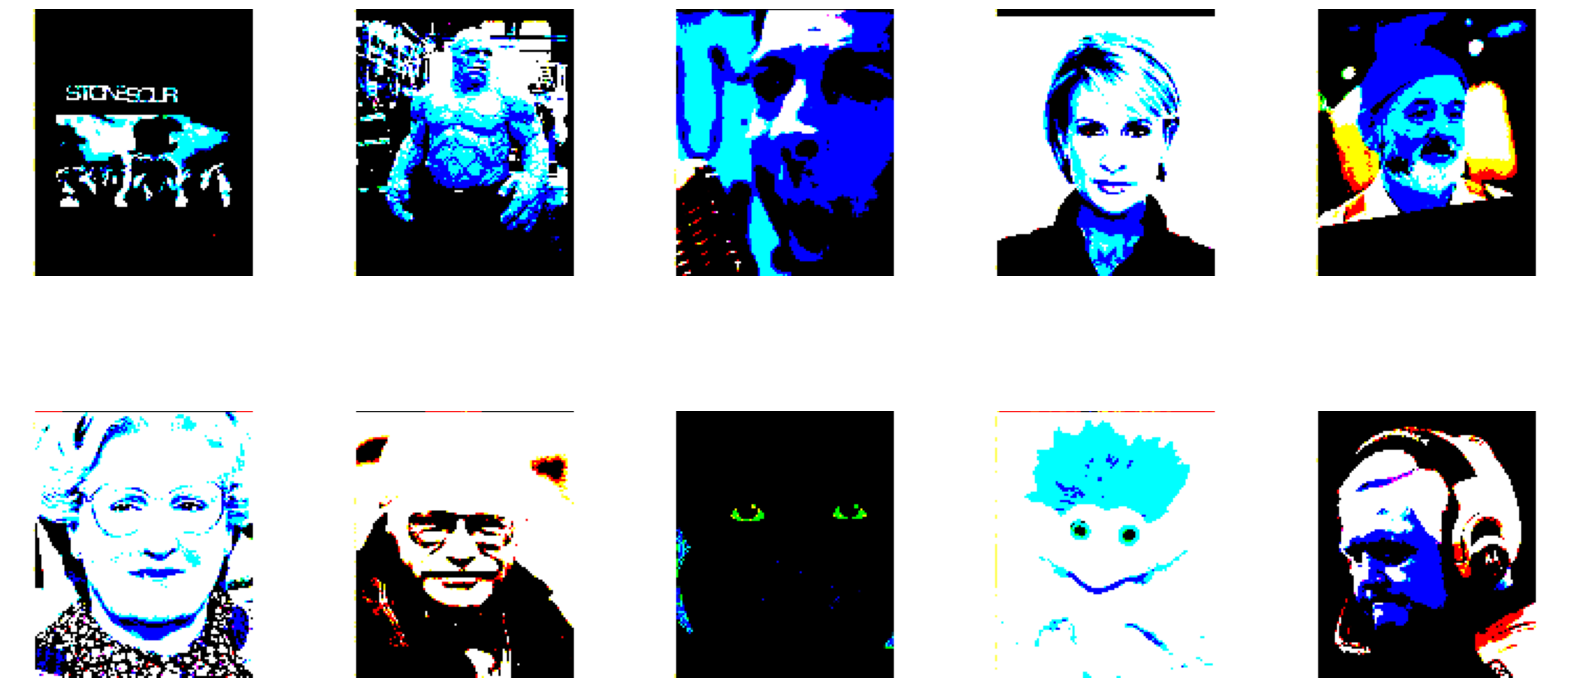

In [8]:
# Check if it's correct

# Get and print the shape of combined_images_array

print(combined_images_array.shape)

# Print the 20 images from the first row
row_images = combined_images_array[0]
plt.figure(figsize=(20, 20))
for i, img in enumerate(row_images):
    plt.subplot(4, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

# Training set processing method

Triplet training

In [9]:
# Create triplet training set
left_images = np.array(train_left_images)  # shape: (2000, 224, 224, 3)
right_images_list = np.array(combined_images_list)  # shape: (2000, 20, 224, 224, 3)

# Initialize an empty list to store triplets
triplets = []

In [10]:
# Iterate through each left image and its associated right image list
for i in range(len(left_images)):
    left_image = left_images[i]
    right_images = right_images_list[i]

    # Get the right image with label 1 (it's always at index 0)
    positive_right_image = right_images[0]

     # Iterate through the right image list, starting from index 1, to create triplets with each right image
    for j in range(1, len(right_images)):
        negative_right_image = right_images[j]

        triplet = [left_image, positive_right_image, negative_right_image]
        triplets.append(triplet)

# Convert the triplet list to a NumPy array
triplets_array = np.array(triplets)

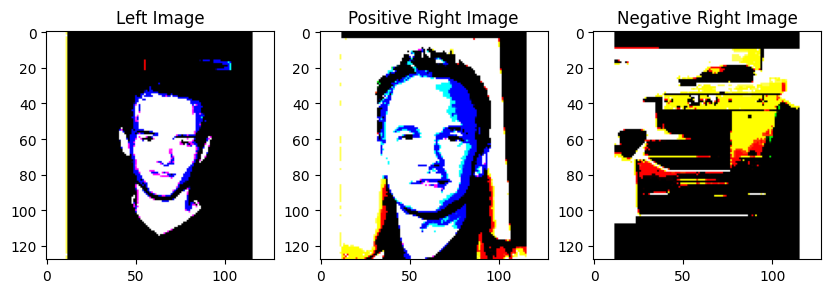

In [11]:
# Check
# Display the images of the first triplet
first_triplet = triplets_array[9]
plt.figure(figsize=(10, 10))
titles = ['Left Image', 'Positive Right Image', 'Negative Right Image']
for k in range(3):
    plt.subplot(1, 3, k+1)
    plt.imshow(first_triplet[k])
    plt.title(titles[k])
plt.show()

#Resnet152

In [12]:
print(triplets_array.ndim)
print(triplets_array.shape)


5
(18000, 3, 128, 128, 3)


In [13]:
del combined_images_array
del right_images_list
del left_images

In [ ]:
# Define the input size for images
input_shape = (128, 128, 3)

# Load the pre-trained ResNet152 model to extract image features
base_model = ResNet152(weights='imagenet', include_top=False, input_shape=input_shape, pooling='avg')

# Define the inputs for the triplet network
anchor_input = Input(shape=input_shape, name='anchor_input')
positive_input = Input(shape=input_shape, name='positive_input')
negative_input = Input(shape=input_shape, name='negative_input')

# Extract image embeddings using the ResNet152 model
anchor_embedding = base_model(anchor_input)
positive_embedding = base_model(positive_input)
negative_embedding = base_model(negative_input)

# Define the triplet loss function
def triplet_loss(inputs, dist='sqeuclidean', margin='maxplus'):
    anchor, positive, negative = inputs
    positive_distance = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    negative_distance = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    if margin == 'maxplus':
        loss = tf.maximum(0.0, positive_distance - negative_distance + 0.2)
    elif margin == 'softplus':
        loss = tf.math.log1p(tf.exp(positive_distance - negative_distance))
    return tf.reduce_mean(loss)

# Compute the triplet loss using a Lambda layer
loss_layer = Lambda(lambda embeddings: triplet_loss(embeddings))( [anchor_embedding, positive_embedding, negative_embedding])

# Construct the model
triplet_model = Model(inputs=[anchor_input, positive_input, negative_input], outputs=loss_layer)

# Compile the model
triplet_model.compile(optimizer=Adam(learning_rate=0.00005), loss=lambda y_true, y_pred: y_pred)

# Split the triplets_array into training and validation sets
train_triplets, val_triplets = train_test_split(triplets_array, test_size=0.1, random_state=42)

# Extract anchor, positive, and negative images from the training set
anchor_train = train_triplets[:, 0]
positive_train = train_triplets[:, 1]
negative_train = train_triplets[:, 2]

# Extract anchor, positive, and negative images from the validation set
anchor_val = val_triplets[:, 0]
positive_val = val_triplets[:, 1]
negative_val = val_triplets[:, 2]

y_dummy_train = np.zeros((len(anchor_train),))
y_dummy_val = np.zeros((len(anchor_val),))

# Define callback functions
early_stopping = EarlyStopping(monitor='loss', patience=5)
model_checkpoint = ModelCheckpoint('model/ResNet152_b32_0.00005_128_model.h5', monitor='loss', save_best_only=True)

234698864/234698864 [==============================] - 12s 0us/step


#Evaluate

In [16]:
#load model

def loss_wrapper(y_true, y_pred):
    return y_pred

# Load the model, providing custom loss function and lambda function wrapper
triplet_model = load_model(
    '/content/drive/MyDrive/MySavedData/model/ResNet152_b32_0.00005_128_model.h5',
    custom_objects={
        'triplet_loss': triplet_loss,
        '<lambda>': loss_wrapper
    }
)

In [ ]:
triplet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 anchor_input (InputLayer)   [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 positive_input (InputLayer  [(None, 128, 128, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 negative_input (InputLayer  [(None, 128, 128, 3)]        0         []                            
 )                                                                                                
                                                                                              

In [21]:
# Get the model's input
anchor_input = triplet_model.get_layer('anchor_input').input
positive_input = triplet_model.get_layer('positive_input').input

# Get the model's embedding output
anchor_embedding_output = triplet_model.get_layer(name='resnet152').get_output_at(0)
positive_embedding_output = triplet_model.get_layer(name='resnet152').get_output_at(1)

# Create a new model to extract embeddings
embedding_model = Model(inputs=[anchor_input, positive_input], outputs=[anchor_embedding_output, positive_embedding_output])

# Use the new model to predict data and get embeddings
anchor_embeddings, positive_embeddings = embedding_model.predict([anchor_train, positive_train])

# Predict embeddings for negative samples using the model
_, negative_embeddings = embedding_model.predict([anchor_train, negative_train])

# Calculate the distance between the anchor and positive samples
positive_distances = np.linalg.norm(anchor_embeddings - positive_embeddings, axis=1)


507/507 [==============================] - 26s 27ms/step


In [ ]:
# 1. Nearest Neighbor Search
# We can use the embeddings of the anchor images to search for the nearest positive image and calculate the model's accuracy.

# Calculate the similarity between the anchor and positive samples
similarities = cosine_similarity(anchor_embeddings, positive_embeddings)

# For each anchor, find the most similar positive sample
top_indices = np.argmax(similarities, axis=1)

# Calculate accuracy
accuracy = np.mean(top_indices == np.arange(len(anchor_embeddings)))
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 3.83%


507/507 [==============================] - 13s 26ms/step


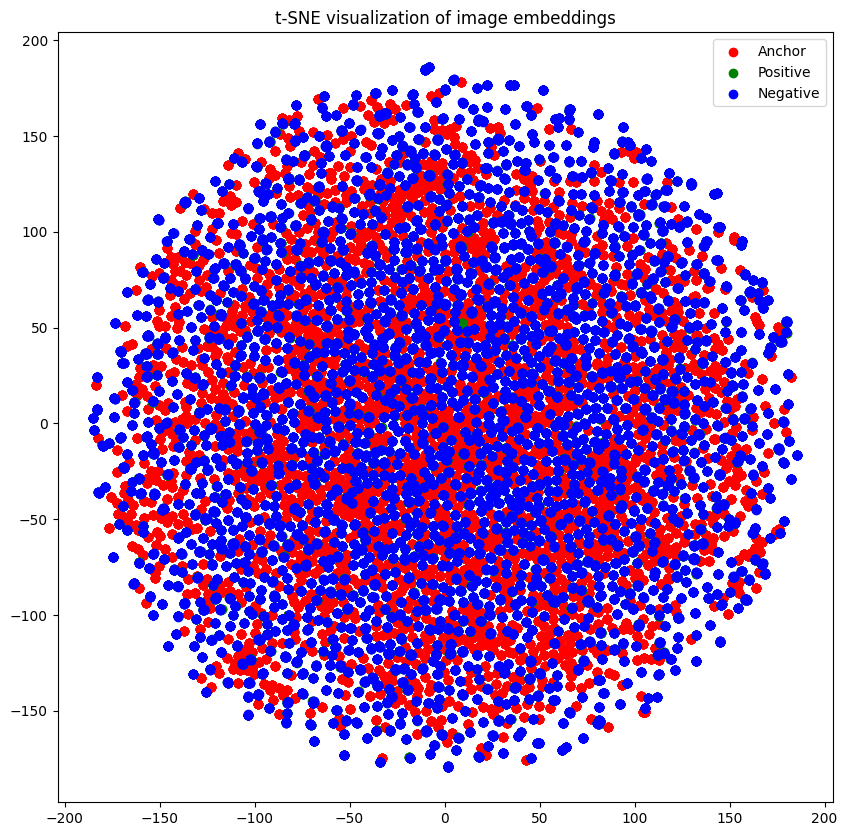

In [25]:
# 2. t-SNE Visualization
# Stack all embeddings into one array
all_embeddings = np.vstack([anchor_embeddings, positive_embeddings, negative_embeddings])

# Reduce dimensionality using t-SNE
embeddings_2d = TSNE(n_components=2).fit_transform(all_embeddings)

# Plot the 2D t-SNE embeddings
plt.figure(figsize=(10, 10))

# Plot anchor embeddings in red
plt.scatter(embeddings_2d[:len(anchor_embeddings), 0],
            embeddings_2d[:len(anchor_embeddings), 1],
            color='r',
            label='Anchor')

# Plot positive embeddings in green
plt.scatter(embeddings_2d[len(anchor_embeddings):len(anchor_embeddings)+len(positive_embeddings), 0],
            embeddings_2d[len(anchor_embeddings):len(anchor_embeddings)+len(positive_embeddings), 1],
            color='g',
            label='Positive')

# Plot negative embeddings in blue
plt.scatter(embeddings_2d[len(anchor_embeddings)+len(positive_embeddings):, 0],
            embeddings_2d[len(anchor_embeddings)+len(positive_embeddings):, 1],
            color='b',
            label='Negative')

# Add legend and title
plt.legend()
plt.title('t-SNE visualization of image embeddings')

# Display the plot
plt.show()

In [ ]:
# Calculate AUC

# Predict embeddings for negative samples using the model
_, negative_embeddings = embedding_model.predict([anchor_train, negative_train])

# Calculate the distance between the anchor and negative samples
negative_distances = np.linalg.norm(anchor_embeddings - negative_embeddings, axis=1)

# Calculate AUC
labels = np.concatenate([np.ones_like(positive_distances), np.zeros_like(negative_distances)])
distances = np.concatenate([positive_distances, negative_distances])
auc = roc_auc_score(labels, -distances)  # The smaller the distance, the higher the similarity
print(f"AUC: {auc:.4f}")

507/507 [==============================] - 14s 28ms/step
AUC: 0.9630


In [ ]:
def calculate_mapk_corrected(anchor_embeddings, positive_embeddings, K=10):
    # Calculate the similarity between all anchors and positive samples
    similarities = cosine_similarity(anchor_embeddings, positive_embeddings)

    # For each anchor, find its K most similar positive samples
    top_k_indices = np.argsort(similarities, axis=1)[:, -K:]

    # Check if the true positive is within the top K for each anchor
    relevant = np.array([i in top_k_indices[j] for j, i in enumerate(range(len(anchor_embeddings)))])

    # Calculate average precision
    avg_precision = np.mean(relevant)

    return avg_precision

# Calculate MAP@K using the corrected function
mapk_corrected_value = calculate_mapk_corrected(anchor_embeddings, positive_embeddings, K=10)
mapk_corrected_value

0.3397530864197531

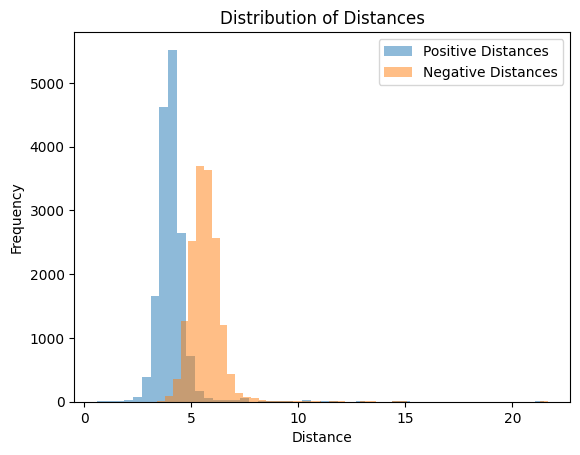

In [ ]:
# Distance Distribution: Viewing the distance distribution between positive and negative samples can help you understand whether the model can distinguish between the two well.
# Calculate distances
positive_distances = np.linalg.norm(anchor_embeddings - positive_embeddings, axis=1)
negative_distances = np.linalg.norm(anchor_embeddings - negative_embeddings, axis=1)

# Visualization
plt.hist(positive_distances, bins=50, alpha=0.5, label='Positive Distances')
plt.hist(negative_distances, bins=50, alpha=0.5, label='Negative Distances')
plt.legend()
plt.title('Distribution of Distances')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()


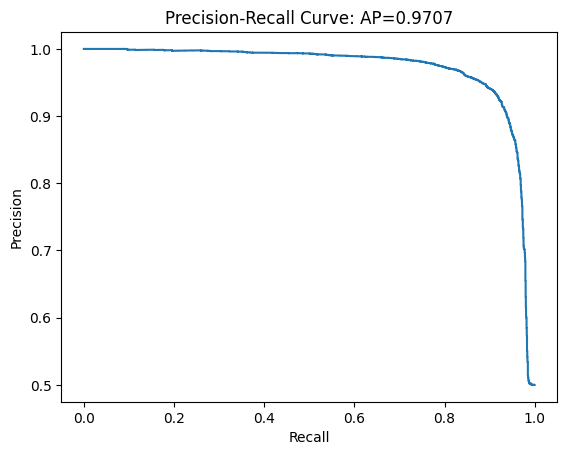

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
# Precision-Recall Curve
# This is another method to evaluate model performance, especially when classes are imbalanced.

# Calculate precision and recall
labels = np.concatenate([np.ones_like(positive_distances), np.zeros_like(negative_distances)])
distances = np.concatenate([positive_distances, negative_distances])
precision, recall, _ = precision_recall_curve(labels, -distances)
average_precision = average_precision_score(labels, -distances)

# Visualization
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve: AP={average_precision:.4f}')
plt.show()


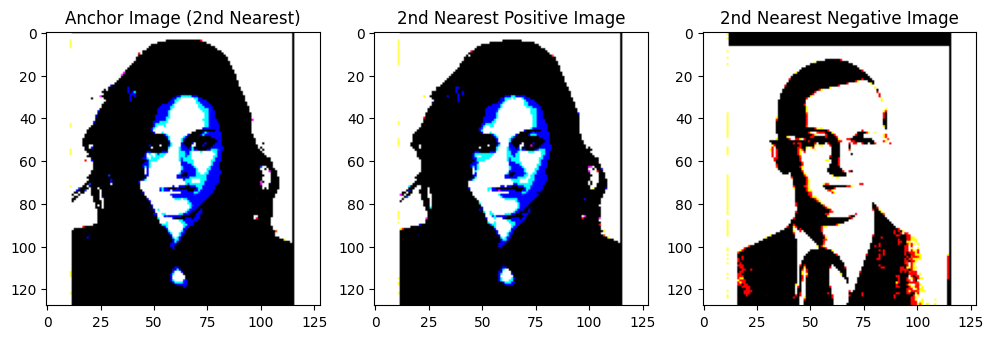

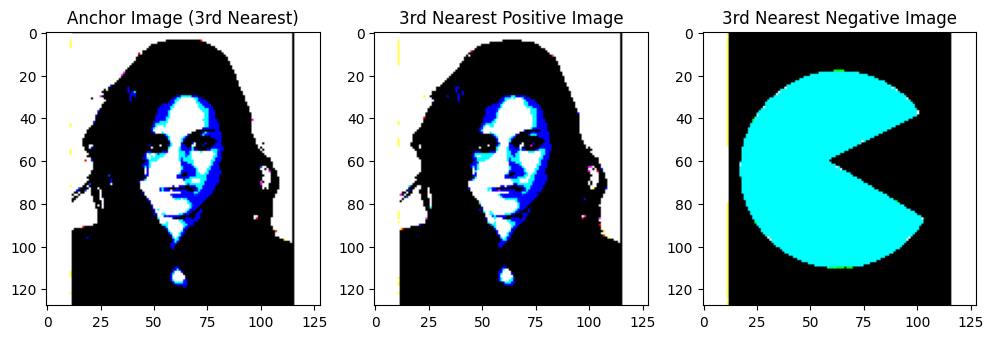

In [ ]:
# Find the second and third nearest positive and negative samples based on the distances calculated earlier
second_nearest_positive_index = np.argsort(positive_distances)[1]
second_nearest_negative_index = np.argsort(negative_distances)[1]

third_nearest_positive_index = np.argsort(positive_distances)[2]
third_nearest_negative_index = np.argsort(negative_distances)[2]

# Retrieve the actual images from the datasets for the second nearest samples
second_nearest_positive_image = positive_train[second_nearest_positive_index]
second_nearest_negative_image = negative_train[second_nearest_negative_index]
anchor_image_second = anchor_train[second_nearest_positive_index]  # Use the same index as the positive since they are paired

# Visualization for the second nearest samples
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(anchor_image_second))
plt.title('Anchor Image (2nd Nearest)')
plt.subplot(1, 3, 2)
plt.imshow(np.squeeze(second_nearest_positive_image))
plt.title('2nd Nearest Positive Image')
plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(second_nearest_negative_image))
plt.title('2nd Nearest Negative Image')
plt.show()

# Retrieve the actual images from the datasets for the third nearest samples
third_nearest_positive_image = positive_train[third_nearest_positive_index]
third_nearest_negative_image = negative_train[third_nearest_negative_index]
anchor_image_third = anchor_train[third_nearest_positive_index]  # Use the same index as the positive since they are paired

# Visualization for the third nearest samples
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(anchor_image_third))
plt.title('Anchor Image (3rd Nearest)')
plt.subplot(1, 3, 2)
plt.imshow(np.squeeze(third_nearest_positive_image))
plt.title('3rd Nearest Positive Image')
plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(third_nearest_negative_image))
plt.title('3rd Nearest Negative Image')
plt.show()


In [ ]:
nearest_positive_index_debug = np.argmin(positive_distances)
nearest_negative_index_debug = np.argmin(negative_distances)

nearest_positive_index_debug, nearest_negative_index_debug

(423, 7111)

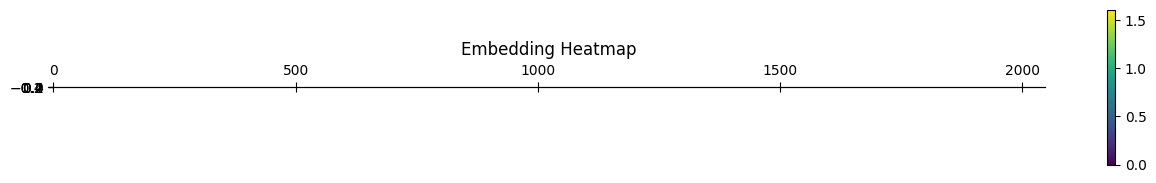

In [ ]:
# Heatmap of Embedding Vectors
# Viewing the heatmap of embedding vectors can help you understand why the model thinks certain images are similar.

# Select an embedding of an anchor image
embedding = anchor_embeddings[0]

# Visualization
plt.matshow(embedding.reshape(1, -1), cmap='viridis')
plt.colorbar()
plt.title('Embedding Heatmap')
plt.show()


#Predict

In [ ]:
# Create a wrapper for the lambda function
def loss_wrapper(y_true, y_pred):
    return y_pred

def triplet_loss(inputs, dist='sqeuclidean', margin='maxplus'):
    anchor, positive, negative = inputs
    positive_distance = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    negative_distance = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    if margin == 'maxplus':
        loss = tf.maximum(0.0, positive_distance - negative_distance + 0.2)
    elif margin == 'softplus':
        loss = tf.math.log1p(tf.exp(positive_distance - negative_distance))
    return tf.reduce_mean(loss)

# Load the model, providing custom loss function and lambda function wrapper
loaded_model = load_model(
    '/model/ResNet152_b32_0.00005_128_model.h5',
    custom_objects={
        'triplet_loss': triplet_loss,
        '<lambda>': loss_wrapper
    }
)


In [ ]:
# Your preprocessing function
def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is not None:
        h, w, _ = image.shape
        diff = abs(h - w)
        pad1, pad2 = diff // 2, diff - diff // 2
        if h > w:
            padding = ((0, 0), (pad1, pad2), (0, 0))
        else:
            padding = ((pad1, pad2), (0, 0), (0, 0))
        image = np.pad(image, padding, mode='constant', constant_values=255)
        image = cv2.resize(image, (128, 128))  # Resize images to 128x128 to match the model's input size
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        image = tf.keras.applications.resnet.preprocess_input(image)
    return np.expand_dims(image, axis=0)  # Add a dimension to match the model's input requirements

# Define paths to your data directories
test_left_dir = 'test/left'
test_right_dir = 'test/right'
test_candidates_file = 'test_candidates.csv'

# Read the CSV file
data = pd.read_csv(test_candidates_file)

# Initialize the results DataFrame
result_df = pd.DataFrame()
result_df['left'] = data['left']

# Get the embedding layer of the model
embedding_layer = loaded_model.get_layer(name='resnet152')

# Record the start time
start_time = time.time()

# Process only the first 2 rows of data
data_subset = data.head(2)
# For partial data: data_subset.iterrows():
# For all data: data.iterrows():

# Iterate through each row of data
for index, row in data.iterrows():
    # Load the left image
    left_img_path = f'{test_left_dir}/{row["left"]}.jpg'
    left_img = load_and_preprocess_image(left_img_path)

    # Get the embedding of the left image
    left_embedding = embedding_layer.predict(left_img)

    # Iterate through the right images
    for i in range(20):
        right_img_name = f'c{i}'
        right_img_path = f'{test_right_dir}/{row[right_img_name]}.jpg'
        right_img = load_and_preprocess_image(right_img_path)

        # Get the embedding of the right image
        right_embedding = embedding_layer.predict(right_img)

        # Calculate the similarity
        similarity = cosine_similarity(left_embedding, right_embedding)[0][0]

        # Add the similarity to the results DataFrame
        result_df.loc[index, right_img_name] = similarity
# Record the end time
end_time = time.time()

# Calculate and print the processing time
elapsed_time_minutes = (end_time - start_time) / 60
print(f'Time taken to process the data: {elapsed_time_minutes:.2f} minutes')

# Save the results to a new CSV file
result_df.to_csv('predict/Predict_ResNet152_b32_0.00005_results.csv', index=False)

# Copy the predictions to the specified directory (assuming you're using Google Colab)
!cp -r "/content/predict" "/content/drive/My Drive/MySavedData"

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 33ms/step
Time taken to process 10 data points: 57.59 minutes
